# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

KeyboardInterrupt: ignored

In [0]:
import warnings
warnings.filterwarnings('ignore')

!pip install fuzzywuzzy

# importing libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests
from fuzzywuzzy import fuzz

import nltk
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.util import ngrams
from collections import Counter
from nltk import tokenize
import re
import gensim
from gensim.models import Word2Vec
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Loading Lexicons

In [0]:
# reading the different lexicons and defining negative words
negative_words = ["no", "not", "not any", "none", "never", "neither", "nor", "few", "hardly", "little", "scarcely", "rarely", "seldom", "isn't", "don't", "can't", "hadn't"]

xlsx_file = '/content/drive/My Drive/Sustainable-Peace-Project/TranslatedLexicon4-8.xlsx'
dfs = pd.read_excel(xlsx_file, sheet_name = 'Positive Peace Terms')
#preprocessing the peace lexicon words 
dfs['English'] = dfs['English'].str.lower()
dfs['English'] = dfs['English'].str.replace("_", " ")
dfs['English'] = dfs['English'].str.strip()
peace_lexicon_list = list(dfs.English)

conflict_file = '/content/drive/My Drive/Sustainable-Peace-Project/TranslatedLexicon4-8.xlsx'
dfs = pd.read_excel(conflict_file, sheet_name = 'Conflict terms')
#preprocessing the conflict lexicon words 
dfs = dfs.dropna()
dfs['English'] = dfs['English'].str.lower()
dfs['English'] = dfs['English'].str.replace("_", " ")
dfs['English'] = dfs['English'].str.strip()
conflict_lexicon_list = list(dfs.English)

nonPeace_file = '/content/drive/My Drive/Sustainable-Peace-Project/TranslatedLexicon4-8.xlsx'
dfs = pd.read_excel(nonPeace_file, sheet_name = 'Resilience Terms')
#preprocessing the non peace lexicon words
dfs = dfs.dropna()
dfs['English'] = dfs['English'].str.lower()
dfs['English'] = dfs['English'].str.replace("_", " ")
dfs['English'] = dfs['English'].str.strip()
nonPeace_lexicon_list = list(dfs.English)

In [0]:
my_stopwords = set(ENGLISH_STOP_WORDS)
for i in negative_words:
  try:
    my_stopwords.remove(i)
  except:
    continue

In [0]:
# preprocessing the lexicons further by removing stem words
peace_processed = []
nonPeace_processed = []
conflict_processed = []
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
for i in peace_lexicon_list:
  input_str = word_tokenize(i)
  input_str_1 = [x for x in input_str if not x in my_stopwords]
  peace_processed.append(' '.join(input_str_1))
for i in nonPeace_lexicon_list:
  input_str = word_tokenize(i)
  input_str_1 = [x for x in input_str if not x in my_stopwords]
  nonPeace_processed.append(' '.join(input_str_1))
for i in conflict_lexicon_list:
  input_str = word_tokenize(i)
  input_str_1 = [x for x in input_str if not x in my_stopwords]
  conflict_processed.append(' '.join(input_str_1))

# Defining functions

In [0]:
# building the gensim model
def build_model(text, lexicon):
  # iterate through each sentence in the file 

  text.append(lexicon)

  model = gensim.models.Word2Vec(text, min_count = 1,  
                                size = 100, window = 5)
  return model

# scraping data from bbc.com
def bbc_news(url):    
    response = requests.get(url, headers={'User-agent': 'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.120 Safari/537.36'})
    soup = BeautifulSoup(response.content, "lxml")
    article = soup.findAll('p') 
    article = article[12:27]
    news_article = ""
    for a in article:
        temp = a.get_text()
        news_article = news_article + " " + temp
    return news_article

# preprocessing with the text
def preprocess_text(text):
    text = re.sub('[!@#$,"()'':-]', '', text.lower())
    sentences = tokenize.sent_tokenize(text)
    words = []
    temp = []
    for x in sentences:
        temp = x.split(' ')
        temp = [x for x in temp if not x in my_stopwords] # removing stop words
        temp = [x.strip('.') for x in temp] 
        temp = [x.strip('') for x in temp]
        words.append(temp)
        temp = []
    return(words)

# functions for finding the peace / non-peace / conflict scores - 
def peace_score(words, lexicon):
    peace_list = []
    t = []
    score = 0
    flag = 0
    for x in words:
        for y in x:
            temp = compare_terms(y, lexicon)
            if y in negative_words and flag == 0:
                # print(y)
                flag = 1
            elif temp != None and flag == 0:
                # print(y + ', ' + temp)
                t.append(y)
                t.append(temp)
                peace_list.append(t)
                t = []
                score = score + 1
            elif temp != None and flag == 1:
                # print(y + ', ' + temp)
                t.append(y)
                t.append(temp)
                peace_list.append(t)
                t = []
                score = score - 1
                flag = 0
        flag = 0
    return peace_list, score

def conflict_score(words, lexicon):
    score = 0
    conflict_list = []
    t = []
    for word in words:
      for y in word:
        temp = compare_terms(y, lexicon)
        if temp != None:
          t.append(y)
          t.append(temp)
          conflict_list.append(t)
          t = []
          score = score + 1
    return conflict_list, score

def nonPeace_score(words, lexicon):
    score = 0
    nonPeace_list = []
    t = []
    for word in words:
      for y in word:
        temp = compare_terms(y, lexicon)
        if temp!=None:
          t.append(y)
          t.append(temp)
          nonPeace_list.append(t)
          t = []
          score = score + 1
    return nonPeace_list, score

# function to compare terms
def compare_terms(term, lexicon):
    for i in lexicon:
      term = term.strip(' ')
      term = term.strip('.')
      # term = term.strip('\'s')
      try:
        if term != '' and fuzz.ratio(term, i) > 85 and model.similarity(term, i) > 0.5:
          return i
      except:
        continue


# scraping data from the Google News API
# this function will find BBC news articles from a particular country in English Language
def google_news_articles(country):
    url = ('https://newsapi.org/v2/everything?'
           'domains=bbc.com&'
           'q=' + country + '&'
           'language=en&'
           'apiKey=78d0091a1deb4db6a93daa7fcafe5985')
    response = requests.get(url)
    #print(response.json())
    news = response.json()['articles']
    desc = []
    for i in range(len(news)):
        desc.append(news[i]['description'])
    url = []
    for i in range(len(news)):
        url.append(news[i]['url'])
    return url, desc

In [0]:
# downloading the Google pretrained model
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-04-27 03:06:00--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.17.179
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.17.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  45.2MB/s    in 35s     

2020-04-27 03:06:35 (44.7 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
model = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

# Loading news articles

In [0]:
canada_file = '/content/drive/My Drive/Sustainable-Peace-Project/canada.csv'
dfs = pd.read_csv(canada_file)
dfs = dfs.drop(columns = 'Unnamed: 0')
dfs.columns = ['Text']
canada_news = list(dfs.Text)
canada_news_total = ' '.join(canada_news)

nz_file = '/content/drive/My Drive/Sustainable-Peace-Project/nz.csv'
dfs = pd.read_csv(nz_file)
dfs = dfs.drop(columns = 'Unnamed: 0')
dfs.columns = ['Text']
nz_news = list(dfs.Text)
nz_news_total = ' '.join(nz_news)

turkey_file = '/content/drive/My Drive/Sustainable-Peace-Project/turkey.csv'
dfs = pd.read_csv(turkey_file)
dfs = dfs.drop(columns = 'Unnamed: 0')
dfs.columns = ['Text']
turkey_news = list(dfs.Text)
turkey_news_total = ' '.join(turkey_news)

venezuela_file = '/content/drive/My Drive/Sustainable-Peace-Project/venezuela.csv'
dfs = pd.read_csv(venezuela_file)
dfs = dfs.drop(columns = 'Unnamed: 0')
dfs.columns = ['Text']
venezuela_news = list(dfs.Text)
venezuela_news_total = ' '.join(venezuela_news)

In [0]:
# preprocessing the text - removing punctuation marks and removing stop words
canada_words = preprocess_text(canada_news_total)
nz_words = preprocess_text(nz_news_total)
turkey_words = preprocess_text(turkey_news_total)
venezuela_words = preprocess_text(venezuela_news_total)

# Finding terms from our lexicon

## Peace Terms

In [0]:
# model = build_model(canada_words, peace_processed)
# canada_words = canada_words[:-1]
cterms, cscore = peace_score(canada_words, peace_processed)
print(cscore)

# model = build_model(nz_words, peace_processed)
# nz_words = nz_words[:-1]
nzterms, nzscore = peace_score(nz_words, peace_processed)
print(nzscore)

# model = build_model(turkey_words, peace_processed)
# turkey_words = turkey_words[:-1]
tterms, tscore = peace_score(turkey_words, peace_processed)
print(tscore)

# model = build_model(venezuela_words, peace_processed)
# venezuela_words = venezuela_words[:-1]
vterms, vscore = peace_score(venezuela_words, peace_processed)
print(vscore)

70
59
66
13


In [0]:
# find the total number of words in each article
word_count = [0,0,0,0]
for i in canada_words:
  word_count[0] = word_count[0] + len(i)
for i in nz_words:
  word_count[1] = word_count[1] + len(i)
for i in turkey_words:
  word_count[2] = word_count[2] + len(i)
for i in venezuela_words:
  word_count[3] = word_count[3] + len(i)
word_count

[3796, 3311, 3891, 900]

In [0]:
cterms1 = [x[1] for x in cterms]
canada_count = Counter(cterms1)
cdf = pd.DataFrame(canada_count.most_common(), columns = ['Terms', 'Frequency'])
cdf.head(10)

,Terms,Frequency
0,positive,10
1,family,4
2,help,4
3,resources,4
4,sports,3
5,spiritual,3
6,culture,3
7,development,3
8,local,2
9,tourism,2


In [0]:
tterms1 = [x[1] for x in tterms]
turkey_count = Counter(tterms1)
tdf = pd.DataFrame(turkey_count.most_common(), columns = ['Terms', 'Frequency'])
tdf.head(10)

,Terms,Frequency
0,help,11
1,agree,9
2,local,7
3,humanitarian,4
4,rights,4
5,agreement,4
6,regime,3
7,media,3
8,solidarity,3
9,happy,3


## Non-peace terns

In [0]:
# model = build_model(canada_words, nonPeace_processed)
# canada_words = canada_words[:-1]
cnpterms, cnpscore = nonPeace_score(canada_words, nonPeace_processed)
print(cnpscore)

# model = build_model(nz_words, nonPeace_processed)
# nz_words = nz_words[:-1]
nznpterms, nznpscore = nonPeace_score(nz_words, nonPeace_processed)
print(nznpscore)

# model = build_model(turkey_words, nonPeace_processed)
# turkey_words = turkey_words[:-1]
tnpterms, tnpscore = nonPeace_score(turkey_words, nonPeace_processed)
print(tnpscore)

# model = build_model(venezuela_words, nonPeace_processed)
# venezuela_words = venezuela_words[:-1]
vnpterms, vnpscore = nonPeace_score(venezuela_words, nonPeace_processed)
print(vnpscore)

30
32
57
7


In [0]:
# new canada score is 27
cnpterms1 = [x[1] for x in cnpterms if x[0] != 'border']
canada_count1 = Counter(cnpterms1)
cdf = pd.DataFrame(canada_count1.most_common(), columns=['Terms', 'Frequency'])
cdf.head(10)

,Terms,Frequency
0,order,7
1,service,6
2,individuals,4
3,payment,3
4,reconciliation,2
5,money,2
6,federal,1
7,justice,1
8,administration,1
9,security,1


In [0]:
cnpterms1 = [x[1] for x in cnpterms]
canada_count1 = Counter(cnpterms1)
canada_count1.most_common()

[('order', 7),
 ('service', 6),
 ('individuals', 4),
 ('payment', 3),
 ('reconciliation', 2),
 ('money', 2),
 ('federal', 1),
 ('justice', 1),
 ('administration', 1),
 ('security', 1),
 ('party', 1),
 ('courts', 1)]

In [0]:
# border coming 39 times and border is compared to order, new score = 33
tnpterms1 = [x[1] for x in tnpterms if x[0] != 'border']
turkey_count1 = Counter(tnpterms1)
tdf = pd.DataFrame(turkey_count1.most_common(), columns=['Terms', 'Frequency'])
tdf.head(10)

,Terms,Frequency
0,refugee,27
1,ceasefires,6
2,security,5
3,order,3
4,union,2
5,truce,2
6,education,2
7,morals,1
8,recovery,1
9,intervention,1


In [0]:
tnpterms1 = [x[1] for x in tnpterms]
turkey_count1 = Counter(tnpterms1)
turkey_count1.most_common()

[('refugee', 27),
 ('ceasefires', 6),
 ('security', 5),
 ('order', 3),
 ('union', 2),
 ('truce', 2),
 ('education', 2),
 ('morals', 1),
 ('recovery', 1),
 ('intervention', 1),
 ('monitoring', 1),
 ('money', 1),
 ('courts', 1),
 ('impartiality', 1),
 ('infrastructure', 1),
 ('individuals', 1),
 ('service', 1)]

## Conflict terms

In [0]:
# model = build_model(canada_words, conflict_processed)
# canada_words = canada_words[:-1]
ccterms, ccscore = nonPeace_score(canada_words, conflict_processed)
print(ccscore)

# model = build_model(nz_words, conflict_processed)
# nz_words = nz_words[:-1]
nzcterms, nzcscore = nonPeace_score(nz_words, conflict_processed)
print(nzcscore)

# model = build_model(turkey_words, conflict_processed)
# turkey_words = turkey_words[:-1]
tcterms, tcscore = nonPeace_score(turkey_words, conflict_processed)
print(tcscore)

# model = build_model(venezuela_words, conflict_processed)
# venezuela_words = venezuela_words[:-1]
vcterms, vcscore = nonPeace_score(venezuela_words, conflict_processed)
print(vcscore)

7
3
36
6


In [0]:
ccterms1 = [x[1] for x in ccterms]
canada_count2 = Counter(ccterms1)
cdf = pd.DataFrame(canada_count2.most_common(), columns = ['Terms', 'Frequency'])
cdf.head(10)

,Terms,Frequency
0,war,3
1,conflict,3
2,crisis,1


In [0]:
tcterms1 = [x[1] for x in tcterms]
turkey_count2 = Counter(tcterms1)
tdf = pd.DataFrame(turkey_count2.most_common(), columns = ['Terms', 'Frequency'])
tdf.head(10)

,Terms,Frequency
0,fighting,9
1,conflict,8
2,crisis,7
3,war,6
4,bomb,3
5,weapons,2
6,destruction,1


# Output Graphs

<BarContainer object of 4 artists>

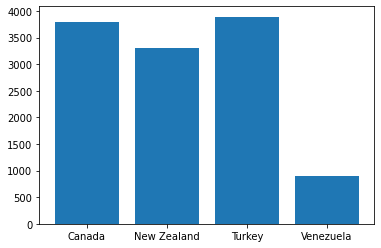

In [0]:
# peace terms
countries = ['Canada', 'New Zealand', 'Turkey', 'Venezuela']
total = [3796, 3311, 3891, 900]
plt.bar(x = countries, height = total)

<BarContainer object of 4 artists>

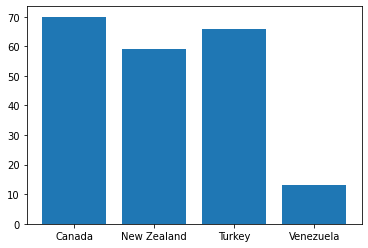

In [0]:
pscore = [70,
59,
66,
13]
plt.bar(x = countries, height = pscore)

<BarContainer object of 4 artists>

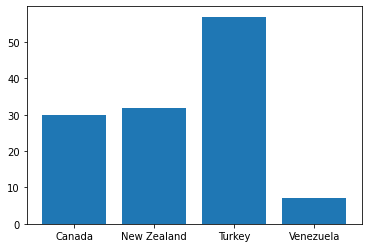

In [0]:
npscore = [30,
32,
57,
7]
plt.bar(x = countries, height = npscore)

<BarContainer object of 4 artists>

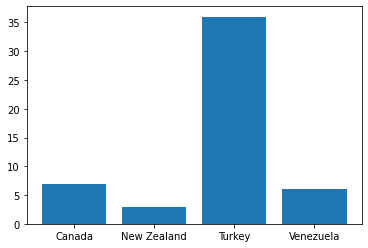

In [0]:
cscore = [7,
3,
36,
6]
plt.bar(x = countries, height = cscore)

In [0]:
columns = ['Total', 'Peace', 'Non-Peace', 'Conflict']
df = pd.DataFrame(columns = columns, index = countries)
df.Total = total
df.Peace = pscore
df['Non-Peace'] = npscore
df.Conflict = cscore
df['Score'] = df['Peace'] + df['Non-Peace'] - df['Conflict']
df

,Total,Peace,Non-Peace,Conflict,Score
Canada,3796,70,30,7,93
New Zealand,3311,59,32,3,88
Turkey,3891,66,57,36,87
Venezuela,900,13,7,6,14


# Using bigrams and trigrams

In [0]:
# changing the nonpeace function a bit
def nonPeace_score1(words, lexicon):
    score = 0
    nonPeace_list = []
    t = []
    for y in words:
      temp = compare_terms(y, lexicon)
      if temp!=None:
        t.append(y)
        t.append(temp)
        nonPeace_list.append(t)
        t = []
        score = score + 1
    return nonPeace_list, score

In [0]:
# using CountVectorizer to generate the word dictionary
cv = CountVectorizer(ngram_range=(1,3), stop_words = my_stopwords, min_df = 2).fit(tokenize.sent_tokenize(canada_news_total))
print("Vocabulary size: ", len(cv.vocabulary_))

Vocabulary size:  916


In [0]:
cv.get_feature_names()

In [0]:
np1, nps1 = nonPeace_score1(cv.get_feature_names(), nonPeace_processed)
np1

[['individual', 'individuals'],
 ['money', 'money'],
 ['order', 'order'],
 ['payment', 'payment'],
 ['reconciliation', 'reconciliation'],
 ['service', 'service'],
 ['services', 'service']]

In [0]:
cv = CountVectorizer(ngram_range=(1,3), stop_words = my_stopwords, min_df = 1).fit(tokenize.sent_tokenize(turkey_news_total))
print("Vocabulary size: ", len(cv.vocabulary_))
np2, nps2 = nonPeace_score1(cv.get_feature_names(), nonPeace_processed)
np2

Vocabulary size:  7540


[['ceasefire', 'ceasefires'],
 ['court', 'courts'],
 ['education', 'education'],
 ['impartial', 'impartiality'],
 ['individual', 'individuals'],
 ['infrastructure', 'infrastructure'],
 ['interventions', 'intervention'],
 ['money', 'money'],
 ['monitoring', 'monitoring'],
 ['moral', 'morals'],
 ['order', 'order'],
 ['recover', 'recovery'],
 ['refugee', 'refugee'],
 ['refugees', 'refugee'],
 ['sanctions', 'sanctions'],
 ['security', 'security'],
 ['services', 'service'],
 ['truce', 'truce'],
 ['union', 'union']]

In [0]:
cv2 = CountVectorizer(ngram_range=(2,2), stop_words = my_stopwords, min_df = 1).fit(tokenize.sent_tokenize(turkey_news_total))
for i in cv2.get_feature_names():
  if i in nonPeace_processed:
    print(i)

asylum seekers
human rights


In [0]:
can_total = [item for sublist in canada_words for item in sublist]
can_counter = Counter(can_total)
can_counter.most_common(20)

[('said', 70),
 ('', 35),
 ('coronavirus', 35),
 ('people', 33),
 ('mr', 33),
 ('not', 32),
 ('cases', 24),
 ('virus', 23),
 ('health', 23),
 ('trump', 20),
 ('deaths', 20),
 ('number', 18),
 ('trudeau', 17),
 ('new', 17),
 ('tested', 15),
 ('confirmed', 15),
 ('country', 15),
 ('canada', 14),
 ('week', 14),
 ('minister', 14)]

In [0]:
tur_total = [item for sublist in turkey_words for item in sublist]
tur_counter = Counter(tur_total)
tur_counter.most_common(20)

[('turkey', 74),
 ('syrian', 58),
 ('said', 57),
 ('migrants', 45),
 ('border', 39),
 ('turkish', 38),
 ('greek', 36),
 ('idlib', 34),
 ('government', 32),
 ('eu', 27),
 ('greece', 26),
 ('not', 26),
 ('president', 26),
 ('forces', 22),
 ('erdogan', 22),
 ('refugees', 22),
 ('', 21),
 ('people', 21),
 ('syria', 20),
 ('russia', 19)]

In [0]:
from nltk import word_tokenize 
from nltk.util import ngrams

can_bigram = []
for token in canada_words:
    bigram = list(ngrams(token, 2)) 
    can_bigram.append(bigram)

can_bigram_total = [item for sublist in can_bigram for item in sublist]

In [0]:
can_bigram_counter = Counter(can_bigram_total)
can_bigram_counter.most_common(20)

[(('prime', 'minister'), 12),
 (('mr', 'trump'), 12),
 (('new', 'york'), 10),
 (('tested', 'positive'), 10),
 (('mr', 'trudeau'), 8),
 (('trump', 'said'), 7),
 (('told', 'reporters'), 7),
 (('n', '̓x̌ax̌aitkʷ'), 7),
 (('spread', 'coronavirus'), 6),
 (('stay', 'home'), 6),
 (('president', 'donald'), 6),
 (('donald', 'trump'), 6),
 (('people', 'died'), 6),
 (('justin', 'trudeau'), 5),
 (('businesses', 'close'), 5),
 (('white', 'house'), 5),
 (('death', 'toll'), 5),
 (('confirmed', 'cases'), 5),
 (('minister', 'justin'), 4),
 (('oil', 'gas'), 4)]

In [0]:
tur_bigram = []
for token in turkey_words:
    bigram = list(ngrams(token, 2)) 
    tur_bigram.append(bigram)

tur_bigram_total = [item for sublist in tur_bigram for item in sublist]

tur_bigram_counter = Counter(tur_bigram_total)
tur_bigram_counter.most_common(20)

[(('syrian', 'government'), 16),
 (('recep', 'tayyip'), 10),
 (('tayyip', 'erdogan'), 10),
 (('turkish', 'soldiers'), 8),
 (('soldiers', 'killed'), 8),
 (('president', 'recep'), 8),
 (('mr', 'erdogan'), 8),
 (('government', 'forces'), 8),
 (('president', 'vladimir'), 6),
 (('vladimir', 'putin'), 6),
 (('turkish', 'president'), 6),
 (('nearly', 'million'), 6),
 (('syrian', 'refugees'), 6),
 (('no', 'longer'), 5),
 (('tear', 'gas'), 5),
 (('greek', 'border'), 5),
 (('greek', 'authorities'), 5),
 (('erdogan', 'said'), 5),
 (('3.7', 'million'), 5),
 (('russian', 'president'), 5)]

In [0]:
can_trigram = []
for token in canada_words:
    trigram = list(ngrams(token, 3)) 
    can_trigram.append(trigram)

can_trigram_total = [item for sublist in can_trigram for item in sublist]
can_trigram_counter = Counter(can_trigram_total)
can_trigram_counter.most_common(20)

[(('president', 'donald', 'trump'), 5),
 (('prime', 'minister', 'justin'), 4),
 (('minister', 'justin', 'trudeau'), 4),
 (('new', 'york', 'state'), 4),
 (('world', 'health', 'organization'), 4),
 (('mr', 'trump', 'said'), 4),
 (('stay', 'home', 'order'), 3),
 (('nonessential', 'businesses', 'close'), 3),
 (('donald', 'trump', 'said'), 3),
 (('canadian', 'prime', 'minister'), 3),
 (('mr', 'trudeau', 'said'), 3),
 (('north', 'atlantic', 'craton'), 3),
 (('tedros', 'adhanom', 'ghebreyesus'), 3),
 (('oil', 'gas', 'sector'), 2),
 (('ordered', 'nonessential', 'businesses'), 2),
 (('patients', 'tested', 'positive'), 2),
 (('tested', 'positive', 'respiratory'), 2),
 (('positive', 'respiratory', 'illness'), 2),
 (('vicepresident', 'mike', 'pence'), 2),
 (('tested', 'positive', 'virus'), 2)]

In [0]:
tur_trigram = []
for token in turkey_words:
    trigram = list(ngrams(token, 3)) 
    tur_trigram.append(trigram)

tur_trigram_total = [item for sublist in tur_trigram for item in sublist]

tur_trigram_counter = Counter(tur_trigram_total)
tur_trigram_counter.most_common(20)

[(('recep', 'tayyip', 'erdogan'), 10),
 (('president', 'recep', 'tayyip'), 7),
 (('syrian', 'government', 'forces'), 7),
 (('turkish', 'soldiers', 'killed'), 6),
 (('president', 'vladimir', 'putin'), 6),
 (('russian', 'president', 'vladimir'), 5),
 (('turkish', 'president', 'recep'), 5),
 (('greek', 'security', 'forces'), 3),
 (('stop', 'migrants', 'crossing'), 3),
 (('syrians', 'fatally', 'shot'), 3),
 (('erdogan', 'said', 'turkey'), 3),
 (('president', 'bashar', 'alassad'), 3),
 (('turkishbacked', 'rebels', 'syrian'), 3),
 (('turkey', 'hosting', '3.7'), 3),
 (('hosting', '3.7', 'million'), 3),
 (('3.7', 'million', 'syrian'), 3),
 (('million', 'syrian', 'refugees'), 3),
 (('fired', 'tear', 'gas'), 3),
 (('syrian', 'observatory', 'human'), 3),
 (('observatory', 'human', 'rights'), 3)]

In [0]:
wn.synsets('hello')[0].pos()

'n'

In [0]:
# trying to find the context of these words 
## Story of 'coronavirus' in context of Canada news
from nltk.corpus import wordnet as wn
texts = []
for i in canada_words:
  for j in i:
    if j == 'coronavirus':
      texts.append(i)
noun=[]
verb=[]
for doc in texts:
  for c in doc:
    if c!= '':
      if len(wn.synsets(c)) != 0:
        if wn.synsets(c)[0].pos()=="n":
            noun.append(c)
        elif wn.synsets(c)[0].pos()=="v":
            verb.append(c)            

([], <a list of 0 Text major ticklabel objects>)

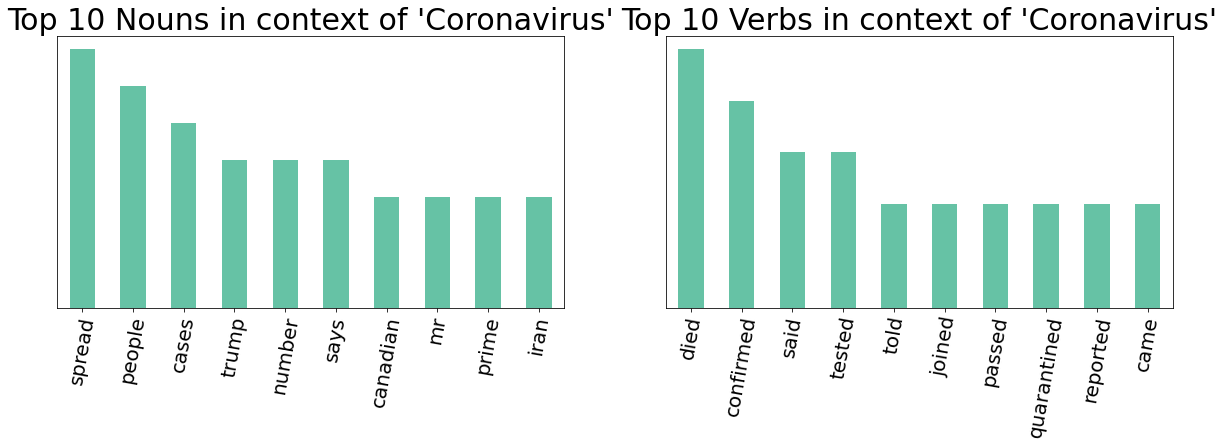

In [0]:
plt.subplot(1,2,1)
pd.Series(noun).value_counts().head(10).plot(kind="bar",figsize=(20,5),colormap="Set2")
plt.title("Top 10 Nouns in context of 'Coronavirus'",fontsize=30)
plt.xticks(size=20,rotation=80)
plt.yticks([])
plt.subplot(1,2,2)
pd.Series(verb).value_counts().head(10).plot(kind="bar",figsize=(20,5),colormap="Set2")
plt.title("Top 10 Verbs in context of 'Coronavirus'",fontsize=30)
plt.xticks(size=20,rotation=80)
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

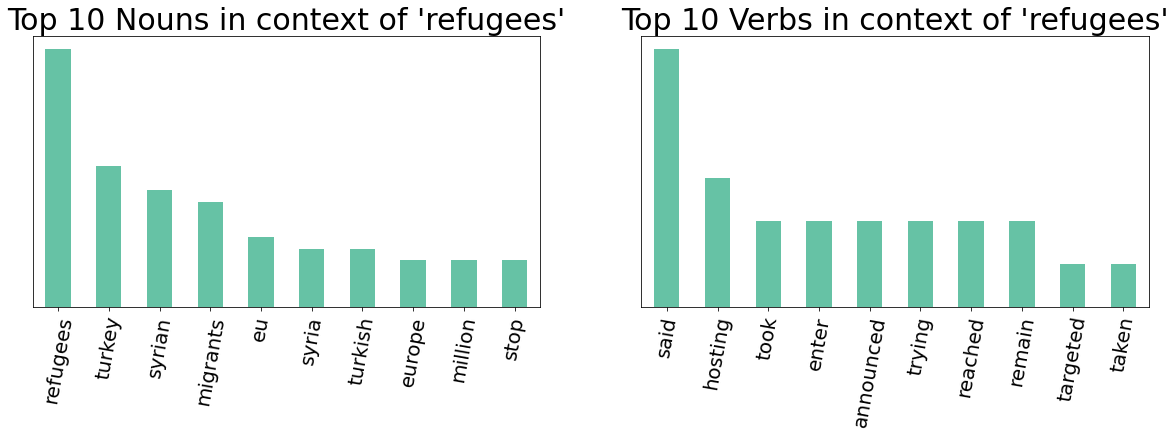

In [0]:
# nouns and verbs in context with word = 'refugees'
texts = []
for i in turkey_words:
  for j in i:
    if j == 'refugees':
      texts.append(i)
noun=[]
verb=[]
for doc in texts:
  for c in doc:
    if c!= '':
      if len(wn.synsets(c)) != 0:
        if wn.synsets(c)[0].pos()=="n":
            noun.append(c)
        elif wn.synsets(c)[0].pos()=="v":
            verb.append(c)

plt.subplot(1,2,1)
pd.Series(noun).value_counts().head(10).plot(kind="bar",figsize=(20,5),colormap="Set2")
plt.title("Top 10 Nouns in context of 'refugees'",fontsize=30)
plt.xticks(size=20,rotation=80)
plt.yticks([])
plt.subplot(1,2,2)
pd.Series(verb).value_counts().head(10).plot(kind="bar",figsize=(20,5),colormap="Set2")
plt.title("Top 10 Verbs in context of 'refugees'",fontsize=30)
plt.xticks(size=20,rotation=80)
plt.yticks([])

# new things

In [0]:
canada_words1 = {k: v for k, v in sorted(canada_words1.items(), key=lambda item: item[1])}
canada_words1

In [0]:
canada_words1 = cv.get_feature_names()
model = build_model(canada_words, peace_processed)
canada_words = canada_words[:-1]
cterms, cscore = peace_score(canada_words1, peace_processed)
print(cscore)

0


In [0]:
canada_words.append(canada_words1)
model = build_model(canada_words, nonPeace_processed)
canada_words = canada_words[:-1]
a, b = nonPeace_score1(canada_words1, nonPeace_processed)
print(b)

4


In [0]:
a

[['order', 'order'],
 ['service', 'service'],
 ['war', 'war'],
 ['world health organization', 'world health organization']]

In [0]:
model = build_model(canada_words, peace_processed)
canada_words = canada_words[:-1]
cterms, cscore = peace_score(canada_words, peace_processed)
print(cscore)

model = build_model(nz_words, peace_processed)
nz_words = nz_words[:-1]
nzterms, nzscore = peace_score(nz_words, peace_processed)
print(nzscore)

model = build_model(turkey_words, peace_processed)
turkey_words = turkey_words[:-1]
tterms, tscore = peace_score(turkey_words, peace_processed)
print(tscore)

model = build_model(venezuela_words, peace_processed)
venezuela_words = venezuela_words[:-1]
vterms, vscore = peace_score(venezuela_words, peace_processed)
print(vscore)